<a href="https://colab.research.google.com/github/patriziodegirolamo/Esame-Questionario/blob/master/train_step_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset from drive.
( You can find the zipped folder [here](https://drive.google.com/file/d/1XsRmyQYHfgRFJCOueXpJ37yyOCrKHO-W/view?usp=sharing))

In [55]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/gdrive/')
data_path = "/content/data"

use_complete_dataset = False


if (use_complete_dataset == True) and (not os.path.isfile('/content/data.zip')):
  print("download entire dataset")
  !gdown --id 1A2dBwPlCyXHTqmG1LRvPfVm6K21jWwUI # 3-5 min
  !jar xf  "/content/data.zip"
elif (use_complete_dataset == False) and (not os.path.isfile('/content/data.zip')):
  # Load cropped dataset containing only 10 images
  print("download cropped dataset")
  !gdown --id 1gPcwDJsNpyqcjKu225hnIxkURpjUA08i   
  !jar xf  "/content/data.zip"
else:
  print("dataset already downloaded")

if not os.path.isdir('/content/data'):
  print("Dataset doesn't exist")

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
dataset already downloaded


# Cloning the repository from github

In [56]:
# Clone the entire repo.
repo_path = "/content/cloned-repo"
if not os.path.isdir(repo_path):
  !git clone -l -s https://github.com/CRosero/aml-project.git cloned-repo
  %cd cloned-repo
else:
  print("Repository already cloned")
%cd /content/cloned-repo
!ls

Repository already cloned
/content/cloned-repo
dataset      image_output  results  train_step_2.ipynb	    train_step_4.ipynb
demo_images  model	   runs     train_step_3.ipynb	    utils
FDA.ipynb    README.md	   scripts  train_step_4_FDA.ipynb


# Importing the libraries

In [57]:
!pip install torchinfo
!pip install -U 'git+https://github.com/facebookresearch/fvcore'

  Cloning https://github.com/facebookresearch/fvcore to /tmp/pip-req-build-kiscxerl
  Running command git clone -q https://github.com/facebookresearch/fvcore /tmp/pip-req-build-kiscxerl


In [58]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.cuda.amp as amp

import torchvision
from torchvision.transforms import InterpolationMode
from torch.utils import data
import torch.nn.functional as F


from utils.utils import reverse_one_hot, compute_global_accuracy, fast_hist, per_class_iu, colour_code_segmentation, poly_lr_scheduler
from utils.loss import CrossEntropy2d,DiceLoss
import numpy as np
import os
import os.path as osp
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
#from torchinfo import summary
#from fvcore.nn import FlopCountAnalysis
import json
import argparse
from tqdm import tqdm

# Dataset class:
from dataset.cityscapesDataSet import cityscapesDataSet
from dataset.GTA5DataSet import GTA5DataSet
# Discriminator
from model.discriminator import FCDiscriminator, LightWeightFCDiscriminator
# Network
from model.build_BiSeNet import BiSeNet
# Validation function
from scripts.eval import val

In [59]:
def enable_cuda(obj, gpu):
  if torch.cuda.is_available():
    return obj.cuda(gpu)
  else:
    return obj

these two functions were deprecated in new realeses of sciPy

In [60]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [61]:
def loss_calc(pred, labels, gpu):
    """
    This function returns cross entropy loss for semantic segmentation
    """
    # out shape batch_size x channels x h x w -> batch_size x channels x h x w
    # label shape h x w x 1 x batch_size  -> batch_size x 1 x h x w
    labels = Variable(labels.long()).cuda(gpu)
    labels = enable_cuda(labels, gpu)
    criterion = CrossEntropy2d()
    criterion = enable_cuda(criterion, gpu)

    return criterion(pred, labels)


def lr_poly(base_lr, iter, max_iter, power):
    return base_lr * ((1 - float(iter) / max_iter) ** (power))


def adjust_learning_rate(optimizer, i_iter):
    lr = lr_poly(args.learning_rate, i_iter, args.num_steps, args.power)
    optimizer.param_groups[0]['lr'] = lr
    if len(optimizer.param_groups) > 1:
        optimizer.param_groups[1]['lr'] = lr * 10


def adjust_learning_rate_D(optimizer, i_iter):
    lr = lr_poly(args.learning_rate_D, i_iter, args.num_steps, args.power)
    optimizer.param_groups[0]['lr'] = lr
    if len(optimizer.param_groups) > 1:
        optimizer.param_groups[1]['lr'] = lr * 10


In [62]:
IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)

MODEL = 'BiseNet'
BATCH_SIZE = 2
#ITER_SIZE = number_of_images // BATCH_SIZE # (500= number of source/target images) -> iter_size is the number of batches
NUM_WORKERS = 4
DATA_DIRECTORY = '/content/data/'
DATA_LIST_PATH = './train.txt'
IGNORE_LABEL = 255
INPUT_SIZE = '1024,512' #'1280,720'
DATA_DIRECTORY_TARGET = './data/Cityscapes'
DATA_LIST_PATH_TARGET = './train.txt'
INPUT_SIZE_TARGET = '1024,512'
LEARNING_RATE = 2.5e-2
MOMENTUM = 0.9
NUM_CLASSES = 19
NUM_STEPS = 50 # number of epochs
NUM_STEPS_STOP = 150
POWER = 0.9
RANDOM_SEED = 1234
RESTORE_FROM =  '/gdrive/MyDrive/Project_AML/Models/checkpoints_segNet/'
SAVE_NUM_IMAGES = 2
SAVE_PRED_EVERY = 1
SNAPSHOT_DIR = '/gdrive/MyDrive/Project_AML/Models/snapshots_segNet/'
WEIGHT_DECAY = 1e-4
CONTEXT_PATH = 'resnet18'

LEARNING_RATE_D = 1e-4
LAMBDA_SEG = 1
LAMBDA_ADV_TARGET = 0.001
GAN = 'Vanilla'
LIGHT_DISCRIMINATOR = True

TARGET = 'Cityscapes'
SET = 'train'

VALIDATION_STEP = 1
LOAD_BEST_MODELS = False
LOAD_LAST_MODELS = True

SAVE_MODELS_PATH = '/gdrive/MyDrive/Project_AML/Models/checkpoints_segNet/'
PRETRAINED_MODELS_PATH= '/gdrive/MyDrive/Project_AML/Models/checkpoints_segNet/latest_CE_loss.pth'
PRETRAINED_BEST_MODELS_PATH= None

AUG_VALUES = None

AUG_VALUES = {
    "hor_flipping_prob" : 1.0, 
    "blur_prob" : 1.0,
    "blur" : 23
}

In [63]:
def get_arguments(params=[]):
    """Parse all the arguments provided from the CLI.
    Returns:
      A list of parsed arguments.
    """
        
    # basic parameters
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", type=str, default=MODEL,
                        help="available options : BiseNet")
    parser.add_argument("--target", type=str, default=TARGET,
                        help="available options : Cityscapes")
    parser.add_argument("--batch-size", type=int, default=BATCH_SIZE,
                        help="Number of images sent to the network in one step.")
    #parser.add_argument("--iter-size", type=int, default=ITER_SIZE,
    #                    help="Accumulate gradients for ITER_SIZE iterations.")
    parser.add_argument("--num-workers", type=int, default=NUM_WORKERS,
                        help="number of workers for multithread dataloading.")
    parser.add_argument("--data-dir", type=str, default=DATA_DIRECTORY,
                        help="Path to the directory containing the source dataset.")
    parser.add_argument("--data-list", type=str, default=DATA_LIST_PATH,
                        help="Path to the file listing the images in the source dataset.")
    parser.add_argument("--ignore-label", type=int, default=IGNORE_LABEL,
                        help="The index of the label to ignore during the training.")
    parser.add_argument("--input-size", type=str, default=INPUT_SIZE,
                        help="Comma-separated string with height and width of source images.")
    parser.add_argument("--data-dir-target", type=str, default=DATA_DIRECTORY_TARGET,
                        help="Path to the directory containing the target dataset.")
    parser.add_argument("--data-list-target", type=str, default=DATA_LIST_PATH_TARGET,
                        help="Path to the file listing the images in the target dataset.")
    parser.add_argument("--input-size-target", type=str, default=INPUT_SIZE_TARGET,
                        help="Comma-separated string with height and width of target images.")
    parser.add_argument("--is-training", action="store_true",
                        help="Whether to updates the running means and variances during the training.")
    parser.add_argument("--learning-rate", type=float, default=LEARNING_RATE,
                        help="Base learning rate for training with polynomial decay.")
    parser.add_argument("--learning-rate-D", type=float, default=LEARNING_RATE_D,
                        help="Base learning rate for discriminator.")
    parser.add_argument("--lambda-seg", type=float, default=LAMBDA_SEG,
                        help="lambda_seg.")
    parser.add_argument("--lambda-adv-target", type=float, default=LAMBDA_ADV_TARGET,
                        help="lambda_adv for adversarial training.")
    parser.add_argument("--momentum", type=float, default=MOMENTUM,
                        help="Momentum component of the optimiser.")
    parser.add_argument("--not-restore-last", action="store_true",
                        help="Whether to not restore last (FC) layers.")
    parser.add_argument("--num-classes", type=int, default=NUM_CLASSES,
                        help="Number of classes to predict (including background).")
    parser.add_argument("--num-steps", type=int, default=NUM_STEPS,
                        help="Number of training steps.")
    parser.add_argument("--num-steps-stop", type=int, default=NUM_STEPS_STOP,
                        help="Number of training steps for early stopping.")
    parser.add_argument("--power", type=float, default=POWER,
                        help="Decay parameter to compute the learning rate.")
    parser.add_argument("--random-mirror", action="store_true",
                        help="Whether to randomly mirror the inputs during the training.")
    parser.add_argument("--random-scale", action="store_true",
                        help="Whether to randomly scale the inputs during the training.")
    parser.add_argument("--random-seed", type=int, default=RANDOM_SEED,
                        help="Random seed to have reproducible results.")
    parser.add_argument("--restore-from", type=str, default=RESTORE_FROM,
                        help="Where restore model parameters from.")
    parser.add_argument("--save-num-images", type=int, default=SAVE_NUM_IMAGES,
                        help="How many images to save.")
    parser.add_argument("--save-pred-every", type=int, default=SAVE_PRED_EVERY,
                        help="Save summaries and checkpoint every often.")
    parser.add_argument("--snapshot-dir", type=str, default=SNAPSHOT_DIR,
                        help="Where to save snapshots of the model.")
    parser.add_argument("--weight-decay", type=float, default=WEIGHT_DECAY,
                        help="Regularisation parameter for L2-loss.")
    parser.add_argument("--gpu", type=int, default=0,
                        help="choose gpu device.")
    parser.add_argument("--set", type=str, default=SET,
                        help="choose adaptation set.")
    parser.add_argument("--gan", type=str, default=GAN,
                        help="choose the GAN objective.")
    parser.add_argument('--context_path', type=str, default=CONTEXT_PATH,
                        help='The context path model you are using, resnet18, resnet101.')
    parser.add_argument('--validation_step', type=int, default=VALIDATION_STEP, help='How often to perform validation (epochs)')
    parser.add_argument('--use_gpu', type=bool, default=True, help='whether to user gpu for training')
    parser.add_argument("--light_discriminator", type=bool, default=LIGHT_DISCRIMINATOR, 
                        help="using discriminator with lightweight depthwise-separable convolutions")
    parser.add_argument('--load_best_models', type=bool, default=LOAD_BEST_MODELS, help='load or not the best models from the saved checkpoint ')
    parser.add_argument('--load_last_models', type=bool, default=LOAD_LAST_MODELS, help='load or not the last models from the saved checkpoint ')
    parser.add_argument('--pretrained_models_path', type=str, default=PRETRAINED_MODELS_PATH, help='path to pretrained models')
    parser.add_argument('--save_models_path', type=str, default=SAVE_MODELS_PATH, help='path to save models')
    parser.add_argument('--pretrained_best_models_path', type=str, default=PRETRAINED_BEST_MODELS_PATH, help='path to the best pretrained models')
    parser.add_argument('--augmentation', type=bool, default=AUG_VALUES, help="if it is true, data augmentation in the source dataset is performed")


    args = parser.parse_args(params)
    return args

In [64]:
#def main(params):
"""Create the model and start the training."""
params = []
args = get_arguments(params)

w, h = map(int, args.input_size.split(','))
input_size = (w, h)

w, h = map(int, args.input_size_target.split(','))
input_size_target = (w, h)

cudnn.benchmark = True
cudnn.enabled = True
gpu = args.gpu

'''
# Create network
if args.model == 'BiseNet':
  model = BiSeNet(num_classes=args.num_classes, context_path= args.context_path)

# Set the network to train mode
model.train()
model = enable_cuda(model, args.gpu)

# init D
if args.light_discriminator == False:
  model_D = FCDiscriminator(num_classes=args.num_classes)
else:
  model_D = LightWeightFCDiscriminator(num_classes=args.num_classes)

# Set the discriminators to train mode
model_D.train()
model_D = enable_cuda(model_D, args.gpu)

# check if the snapshot dir exists, if not create it
if not os.path.exists(args.snapshot_dir):
  os.makedirs(args.snapshot_dir)
'''

"\n# Create network\nif args.model == 'BiseNet':\n  model = BiSeNet(num_classes=args.num_classes, context_path= args.context_path)\n\n# Set the network to train mode\nmodel.train()\nmodel = enable_cuda(model, args.gpu)\n\n# init D\nif args.light_discriminator == False:\n  model_D = FCDiscriminator(num_classes=args.num_classes)\nelse:\n  model_D = LightWeightFCDiscriminator(num_classes=args.num_classes)\n\n# Set the discriminators to train mode\nmodel_D.train()\nmodel_D = enable_cuda(model_D, args.gpu)\n\n# check if the snapshot dir exists, if not create it\nif not os.path.exists(args.snapshot_dir):\n  os.makedirs(args.snapshot_dir)\n"

In [72]:
def print_solutions(im, RGB = True):

  im = torch.squeeze( im)
  im = np.array((im - im.min()) * 255.0 /
                      (im.max() - im.min()), np.uint8)
  

  
  im = im.transpose((1,2,0)) #from channels, heidth, width ->heidth, width, channels
  
  
  if ( RGB): 
    im = im[:,:,::-1]
    
  
  src_in_trg = Image.fromarray(im,mode="RGB")
  
  ### PRINT RESULTS ###
  images = [im]
  titles = ["Source (GTA)"]
  plt.figure(figsize=(20,10))
  columns = len(images)
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.title(titles[i])
      plt.imshow(image)

In [66]:
args.augmentation

{'blur': 23, 'blur_prob': 1.0, 'hor_flipping_prob': 1.0}

GTA:  10
Cityscapes:  10
flipping
blurring
GTA image (3, 512, 1024)
GTA label (512, 1024)
Cityscapes image (3, 512, 1024)
Iter_Size =  5
flipping
flipping
blurring
blurring
flipping
flipping
blurring
blurring
flipping
blurring
flipping
blurring
flipping
blurring
flipping
blurring


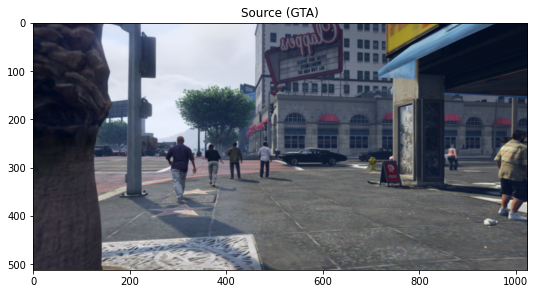

In [73]:
# Path
source_data_root_path = os.path.join(args.data_dir, "GTA5") # /content/data/GTA5
target_data_root_path = os.path.join(args.data_dir, args.target) # /content/data/Cityscapes
source_train_path = os.path.join(source_data_root_path, "train.txt") # /content/data/GTA5/train.txt
target_root_path = os.path.join(target_data_root_path,  "train.txt")   # /content/data/Cityscapes/train.txt
info_path = os.path.join(source_data_root_path,  "info.json") # /content/data/GTA/info.json 

info_json = json.load(open(info_path))

# Datasets  
source_dataset = GTA5DataSet(source_data_root_path, source_train_path, info_json, crop_size=input_size, scale=args.random_scale, mirror=args.random_mirror, mean=IMG_MEAN, augmentation=args.augmentation)
target_dataset = cityscapesDataSet(target_data_root_path, target_root_path, info_json, crop_size=input_size_target, scale=False, mirror=args.random_mirror, mean=IMG_MEAN)

print("GTA: ", len(source_dataset))
print("Cityscapes: ", len(source_dataset))
img,label = source_dataset[0]
print ("GTA image", img.shape )
print ("GTA label", label.shape )
img, _ = target_dataset[0]
print ("Cityscapes image", img.shape )

# Itersize
assert len(source_dataset)==len(target_dataset)
iter_size = len(source_dataset) // args.batch_size # the source and the target have the same len
print("Iter_Size = ", iter_size)

# Create DataLoaders
trainloader = data.DataLoader(source_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)
trainloader_iter = enumerate(trainloader)

targetloader = data.DataLoader(target_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)
targetloader_iter = enumerate(targetloader)

targetloaderVal = data.DataLoader(source_dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

targetloaderVal_iter = enumerate(targetloaderVal)
for i in range(1):
  
  _, batch = next(targetloaderVal_iter)
  target_images, _ = batch
  print_solutions(target_images)
